# Newell-Lee Evaporator 

Solve the following IVP to simulate the Evaporator example from Pilario et al. (2020):

$$ \frac{dL_2}{dt} = \frac{F_1-F_4-F_2}{20}$$

$$ \frac{dX_2}{dt} = \frac{F_1 X_1 - F_2 X_2}{20} $$

$$ \frac{dP_2}{dt} = \frac{F_4 - F_5}{4} $$

Apply a step input on F2 from $2\,\mathrm{kg/min}$ to $3\,\mathrm{kg/min}$ at $t=2\,\mathrm{min}$.

In [1]:
from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt

Please recompile / update your pynumero_ASL library.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      341

Total number of variables............................:      713
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      124
                     variables w

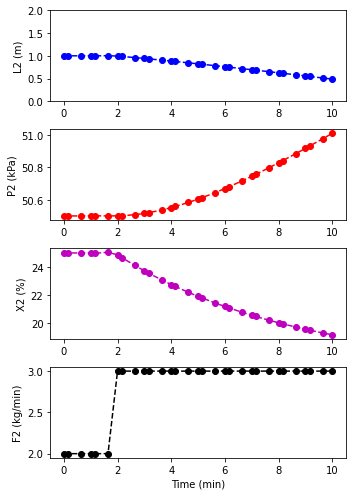

In [2]:
evap = ConcreteModel()

evap.tf = Param(initialize=10)
evap.t = ContinuousSet(bounds=(0,evap.tf))

# States
evap.L2 = Var(evap.t, initialize=1, bounds=(0, 2))
evap.P2 = Var(evap.t, initialize=50.5)
evap.X2 = Var(evap.t, initialize=25)

# Inputs and Disturbances
evap.F200 = Var(evap.t, initialize=208, bounds=(0, 400))
evap.P100 = Var(evap.t, initialize=194.7, bounds=(0, 400))
evap.T200 = Var(evap.t, initialize=25)
evap.F1 = Var(evap.t, initialize=10)
evap.F2 = Var(evap.t, initialize=2, bounds=(0, 4))
evap.X1 = Var(evap.t, initialize=5)
evap.T1 = Var(evap.t, initialize=40)
evap.F3 = Var(evap.t, initialize=50)

# Other outputs
evap.F4 = Var(evap.t, initialize=8)
evap.F5 = Var(evap.t, initialize=8)
evap.T2 = Var(evap.t, initialize=84.6)
evap.T3 = Var(evap.t, initialize=80.6)
evap.F100 = Var(evap.t, initialize=9.27)
evap.T100 = Var(evap.t, initialize=119.9)
evap.Q100 = Var(evap.t, initialize=339.2)
evap.T201 = Var(evap.t, initialize=46.15)
evap.Q200 = Var(evap.t, initialize=308)

# Setup derivative vars for states
evap.dL2dt = DerivativeVar(evap.L2)
evap.dP2dt = DerivativeVar(evap.P2)
evap.dX2dt = DerivativeVar(evap.X2)

#evap.obj = Objective(expr=evap.X2[evap.tf], sense=maximize)
evap.obj = Objective(expr=1)

def _z1dot(m, i):
    return m.dL2dt[i]*20 == m.F1[i] - m.F4[i] - m.F2[i]
evap.z1dot = Constraint(evap.t, rule = _z1dot)

def _z2dot(m, i):
    return m.dX2dt[i]*20 == m.F1[i]*m.X1[i] - m.F2[i]*m.X2[i]
evap.z2dot = Constraint(evap.t, rule = _z2dot)

def _z3dot(m, i):
    return m.dP2dt[i]*4 == m.F4[i] - m.F5[i]
evap.z3dot = Constraint(evap.t, rule = _z3dot)

# Other constraints
def _con1(m, i):
    return m.T2[i] == 0.5616*m.P2[i] + 0.3126*m.X2[i] + 48.43
evap.con1 = Constraint(evap.t, rule=_con1)

def _con2(m, i):
    return m.T3[i] == 0.507*m.P2[i] + 55    
evap.con2 = Constraint(evap.t, rule=_con2)

def _con3(m, i):
    return m.F4[i]*38.5 == m.Q100[i] - 0.07*m.F1[i]*(m.T2[i] - m.T1[i])
evap.con3 = Constraint(evap.t, rule=_con3)

def _con4(m, i):
    return m.T100[i] == 0.1538*m.P100[i] + 90
evap.con4 = Constraint(evap.t, rule=_con4)

def _con5(m, i):
    return m.Q100[i] == 0.16*(m.F1[i] + m.F3[i])*(m.T100[i] - m.T2[i])
evap.con5 = Constraint(evap.t, rule=_con5)

def _con6(m, i):
    return m.F100[i]*36.6 == m.Q100[i]
evap.con6 = Constraint(evap.t, rule=_con6)

def _con7(m, i):
    return m.Q200[i]*(0.14*m.F200[i]+6.84) == 0.9576*m.F200[i]*(m.T3[i]-m.T200[i])
evap.con7 = Constraint(evap.t, rule=_con7)

def _con8(m, i):
    return m.T201[i] == m.T200[i] + m.Q200[i]/0.07/m.F200[i]
evap.con8 = Constraint(evap.t, rule=_con8)

def _con9(m, i):
    return m.F5[i]*38.5 == m.Q200[i]
evap.con9 = Constraint(evap.t, rule=_con9)

def _init(m):
    yield m.L2[0] == 1.0
    yield m.P2[0] == 50.5
    yield m.X2[0] == 25
    
evap.initcon = ConstraintList(rule=_init)

def _step(m, i):
    if i < 2:
        return m.F2[i] == 2
    else:
        return m.F2[i] == 3

evap.step = Constraint(evap.t, rule=_step)

# Set all other inputs (incl. disturbances) as constant over time
evap.F200con = Constraint(evap.t, rule=lambda m, i: m.F200[i] == 208)
evap.P100con = Constraint(evap.t, rule=lambda m, i: m.P100[i] == 194.7)
evap.T200con = Constraint(evap.t, rule=lambda m, i: m.T200[i] == 25)
evap.F1con   = Constraint(evap.t, rule=lambda m, i: m.F1[i] == 10)
#evap.F2con   = Constraint(evap.t, rule=lambda m, i: m.F2[i] == 2)
evap.F3con   = Constraint(evap.t, rule=lambda m, i: m.F3[i] == 50)
evap.X1con   = Constraint(evap.t, rule=lambda m, i: m.X1[i] == 5)
evap.T1con   = Constraint(evap.t, rule=lambda m, i: m.T1[i] == 40)

# Discretize using collocation
#discretizer = TransformationFactory('dae.finite_difference')
#discretizer.apply_to(evap, nfe=50, scheme='BACKWARD')

discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(evap, nfe=10, ncp=3 , scheme='LAGRANGE-RADAU')

# Solve using Pyomo IPOPT
solver = SolverFactory('cyipopt')
solver.solve(evap, tee=True)

colloc_t = list(evap.t)
colloc_L2 = [value(evap.L2[i]) for i in evap.t]
colloc_P2 = [value(evap.P2[i]) for i in evap.t]
colloc_X2 = [value(evap.X2[i]) for i in evap.t]
colloc_F2 = [value(evap.F2[i]) for i in evap.t]

plt.figure(figsize=(5, 7))
plt.subplot(411)
plt.plot(colloc_t,colloc_L2,'bo--')
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylim([0, 2])
plt.ylabel('L2 (m)')
plt.subplot(412)
plt.plot(colloc_t,colloc_P2,'ro--')
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('P2 (kPa)')
plt.subplot(413)
plt.plot(colloc_t,colloc_X2,'mo--')
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('X2 (%)')
plt.subplot(414)
plt.plot(colloc_t,colloc_F2,'ko--')
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('F2 (kg/min)')
plt.xlabel('Time (min)')
plt.tight_layout()
plt.show()